# Import packages and set settings

In [1]:
%load_ext autoreload
%autoreload 2

import sys
# sys.path.insert(1, './python_mods/')
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving

In [2]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
import collections

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Functions

In [5]:
def recalc_mses(model_fxns, EA_theta_set, exp_data, exp_time, params_constants, initials, ptpD=False):
    mses = []
    for params in EA_theta_set:
        mses.append(sum(model_supp.calc_sim_score(model_fxns, params, exp_data, exp_time, params_constants, initials, ptpD=False)[:18]))
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = EA_theta_set[re_idx]
    mses = np.sort(mses)
    return mses, thetas

def sort_mses_thetas(mses, thetas):
    re_idx = sorted(range(len(mses)), key=lambda k: mses[k])
    thetas = thetas[re_idx]
    return np.sort(mses), thetas

def calc_mse(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD=False):
    # Takes 
    return sum(model_supp.calc_sim_score(model_fxns, theta, exp_data, exp_time, params_constants, initials, ptpD)[:18]) ##AMY (insert your own error function)

def def_schedules(sorted_mses):
    best_mse = sorted_mses[0]
    worst_mse = sorted_mses[-1]
    
#     e1 = (best_mse+worst_mse)/2 #will take longer to run
    e1 = worst_mse
    e2 = (e1+best_mse)/2
    e3 = (e2+best_mse)/2
    e4 = (e3+best_mse)/2
#     e5 = (e4+best_mse)/2
    return e1, e2, e3, e4
    
def scaled_prob_mses(mses, top=.99, bot=.01):
    # mses is SORTED 
    scale = [(top-bot)*(x-mses[0])/(mses[-1]-mses[0])+bot for x in mses]
    inv = [1/x for x in scale]
    probs = [x/sum(inv) for x in inv]
    return probs

def draw_thetas(sorted_params, probs):
    idx = np.random.choice(range(len(sorted_params)), 1, p=probs)
    return sorted_params[idx][0]

def step_theta(theta):
    log_theta = np.log10(theta) 
    theta_prime = np.concatenate([10**(np.random.uniform(x-.1,x+.1,1)) for x in log_theta], axis=0)
    return theta_prime

def run_schedule(prior_thetas, probs, ei, num_theta_primes):
    thetas_ei = []
    mses_ei = []
    c = collections.Counter({'Pass': 0, 'Fail': 0}) 
    while len(thetas_ei) < num_theta_primes:
        theta = draw_thetas(prior_thetas, probs)
        theta_prime = step_theta(theta)
        mse = calc_mse(M1_fxns, theta_prime, exp_data, exp_time, params_constants, initials, ptpD=False) ##AMY error fxn
        if mse < ei:
            c['Pass'] += 1
            thetas_ei.append(theta_prime)
            mses_ei.append(mse)
            if len(mses_ei) % int(num_theta_primes*.1) == 0:
                print(str(int(len(mses_ei)/num_theta_primes*100)) + "% complete.") 
        else:
            c['Fail'] += 1
    return np.asarray(mses_ei), np.asarray(thetas_ei), c

# Model

## Model Variables (Constants)

In [6]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)


MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on

labelnames = ['$- fb_1$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$',
              '$k_2$', '$k_4$', '$k_6$', 
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']

minimums = [-4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4
        ]

maximums = [ 4, 4,
        4, 4, 4, 4,
        4, 4, 4, 4,
        4, 4, 4, 4
        ]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

initials = [MAP3K, MAP2K, MAPK]

params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 

doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]

# Load experimental data

In [8]:
exp_data, exp_time = model_supp.get_data()

mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data, mapk_ptpD_data = exp_data
mapk_time, mapk_time_t100a_long, mapk_ramp_time = exp_time 

mapk_data_t100a_long = [mapk_t100a_data[0]] 

mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:] #shorten for plotting

min_doses = [150000,550000]
min_wt_data = [mapk_wt_data[2], mapk_wt_data[6]]
min_t100a_data = [mapk_t100a_data[2], mapk_t100a_data[6]]

# Load simulation data

In [9]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190924_kb_M1/'

all_params, last_params, all_mses, last_mses = model_supp.get_sim_data(folder, num_sims=2000)



Number of runs collected: 1809
Best last gen MSE: 3379.991643387466
Mean last gen MSEs of top 5%: 6331.774452553364


In [10]:
M1_fxns = model.Model(model.M1_kb, model.simulate_t100a_experiment_M1)

In [15]:
## sort
M1_sorted_mses_EA, M1_sorted_thetas_EA = sort_mses_thetas(last_mses, last_params)

# Check EA results

No handles with labels found to put in legend.


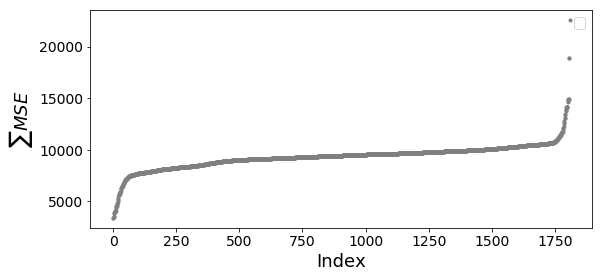

In [13]:
plotting.plt_idx_vs_mse(M1_sorted_mses_EA, len(M1_sorted_mses_EA))

No handles with labels found to put in legend.


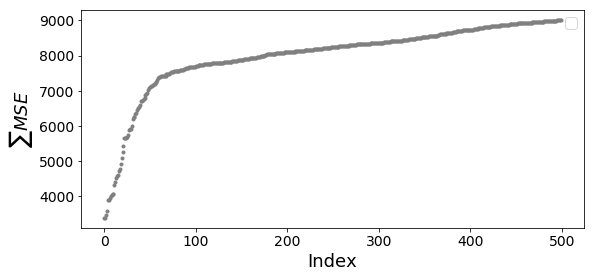

In [15]:
plotting.plt_idx_vs_mse(M1_sorted_mses_EA, 500)

No handles with labels found to put in legend.


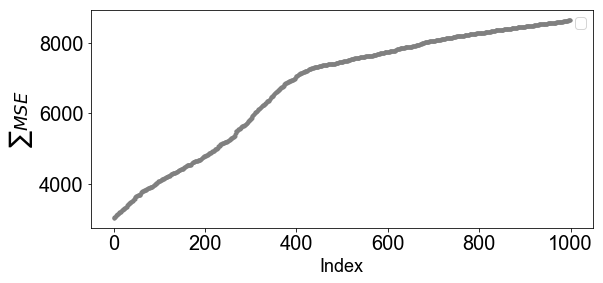

In [61]:
plotting.plt_idx_vs_mse(mses_e1_sort, 1000)

## Figure 3

In [11]:
folder_base = 'C:/Users/sksuzuki/Documents/Research/figures/paper1/fig2/'

In [12]:
pre_ea_params = [all_params[i][0] for i in range(len(all_params))]

In [13]:
min_doses = [150000,550000]
min_mapk_wt_data = [mapk_wt_data[2], mapk_wt_data[6]]

min_mapk_t100a_data = [mapk_t100a_data[2], mapk_t100a_data[6]]

In [16]:
# sim_data_plt = [pre_ea_params, M1_sorted_thetas_EA, thetas_e4_sort_M2b_kb]
# exp_data_plt = [min_mapk_wt_data, min_mapk_t100a_data]

NameError: name 'thetas_e4_sort_M2b_kb' is not defined

Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


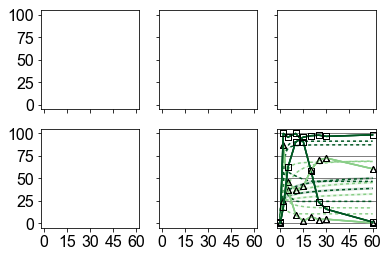

In [165]:
# plotting.plt_param_cis_fig3c(M1_fxns, sim_data_plt, params_constants, initials, time,
#                         exp_data=exp_data_plt, exp_time=mapk_time, ss=False, t100a=False, ptpD=False, ci= 95,
#                         save_fig=folder_base+'all')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

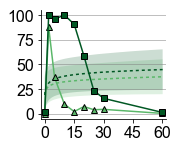

In [29]:
plotting.plt_param_cis(M1_fxns, pre_ea_params, params_constants, initials, min_doses, time, 2,
                        exp_data=min_mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig=folder_base+'113')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

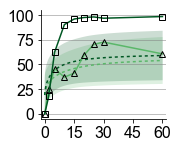

In [30]:
plotting.plt_param_cis(M1_fxns, pre_ea_params, params_constants, initials,  min_doses, time, 2,
                        exp_data=min_mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig=folder_base+'213')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

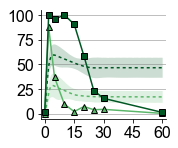

In [31]:
plotting.plt_param_cis(M1_fxns, M1_sorted_thetas_EA, params_constants, initials,   min_doses, time, 2,
                        exp_data=min_mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig=folder_base+'123')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

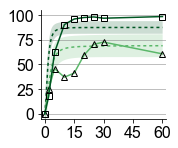

In [32]:
plotting.plt_param_cis(M1_fxns, M1_sorted_thetas_EA, params_constants, initials,  min_doses, time, 2,
                        exp_data=min_mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig=folder_base+'223')

In [20]:
thetas_e4_sort_M2b_kb = np.array(pd.read_csv("M1_kb_thetas_e4.csv").drop(['Unnamed: 0'], axis=1))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

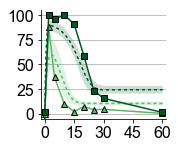

In [33]:
plotting.plt_param_cis(M1_fxns, thetas_e4_sort_M2b_kb, params_constants, initials,  [150000,550000], time, 2,
                        exp_data=[mapk_wt_data[2], mapk_wt_data[6]], exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig=folder_base+'313')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

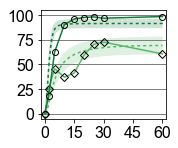

In [178]:
plotting.plt_param_cis(M1_fxns, thetas_e4_sort_M2b_kb, params_constants, initials,  [150000,550000], time, 2,
                        exp_data=[mapk_t100a_data[2], mapk_t100a_data[6]], exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig=folder_base+'323')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

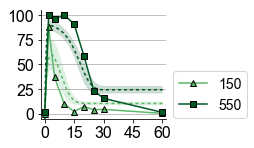

In [36]:
plotting.plt_param_cis(M1_fxns, thetas_e4_sort_M2b_kb, params_constants, initials,  [150000,550000], time, 2,
                        exp_data=[mapk_wt_data[2], mapk_wt_data[6]], exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig=folder_base+'31l')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

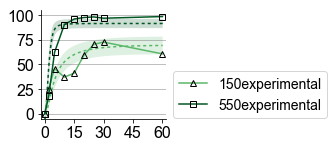

In [42]:
plotting.plt_param_cis(M1_fxns, thetas_e4_sort_M2b_kb, params_constants, initials,  [150000,550000], time, 2,
                        exp_data=[mapk_t100a_data[2], mapk_t100a_data[6]], exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig=folder_base+'32l')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

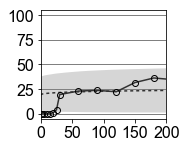

In [104]:
time_long = np.linspace(0,dt*2001,steps)

plotting.plt_param_cis(M1_fxns, pre_ea_params, params_constants, initials,  [0], time_long, 2,
                        exp_data=mapk_data_t100a_long, exp_time=mapk_time_t100a_long, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig=folder_base+'51')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

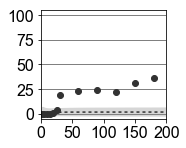

In [104]:
time_long = np.linspace(0,dt*2001,steps)

plotting.plt_param_cis(M1_fxns, M1_sorted_thetas_EA, params_constants, initials,  [0], time_long, 2,
                        exp_data=mapk_data_t100a_long, exp_time=mapk_time_t100a_long, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig=folder_base+'52')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

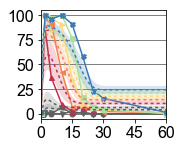

In [53]:
plotting.plt_param_cis(M1_fxns, thetas_e4_sort_M2b_kb, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_wt_data, exp_time=mapk_time, ss=True, t100a=False, ptpD=False, ci='sd',
                        save_fig=folder_base+'test14')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 50000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 150000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 250000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 350000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 450000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Dose: 550000 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

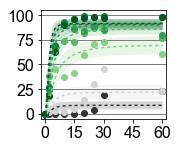

In [99]:

plotting.plt_param_cis(M1_fxns, thetas_e4_sort_M2b_kb, params_constants, initials,  doses, time, 2,
                        exp_data=mapk_t100a_data, exp_time=mapk_time, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig=folder_base+'23')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Dose: 0 complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


<Figure size 720x576 with 0 Axes>

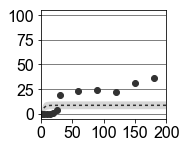

In [105]:
time_long = np.linspace(0,dt*2001,steps)

plotting.plt_param_cis(M1_fxns, thetas_e4_sort_M2b_kb, params_constants, initials,  [0], time_long, 2,
                        exp_data=mapk_data_t100a_long, exp_time=mapk_time_t100a_long, ss=True, t100a=True, ptpD=False, ci='sd',
                        save_fig=folder_base+'53')

### Params

In [ ]:
df_top_thetas_EA = pd.DataFrame(M1_sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 200
df_plt = pd.DataFrame(M1_sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

## Plotting cont,

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

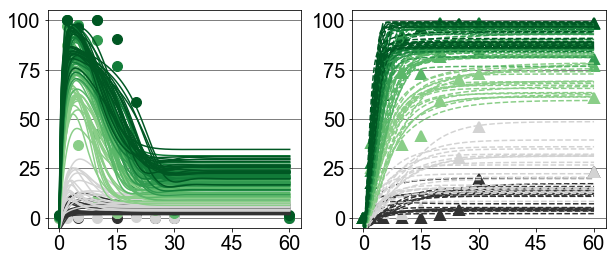

In [18]:
# original parameter values
plotting.plt_param_behaviors(M1_fxns, M1_sorted_thetas_EA, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

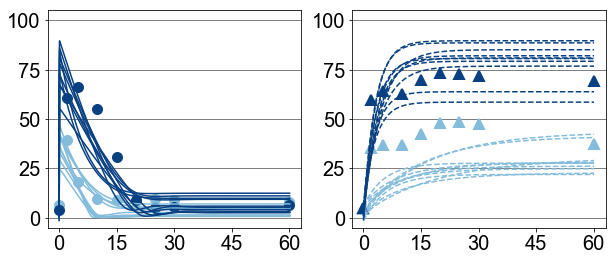

In [19]:
plotting.plt_param_behaviors(M1_fxns, M1_sorted_thetas_EA, 10, params_constants, initials,  [150000,550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

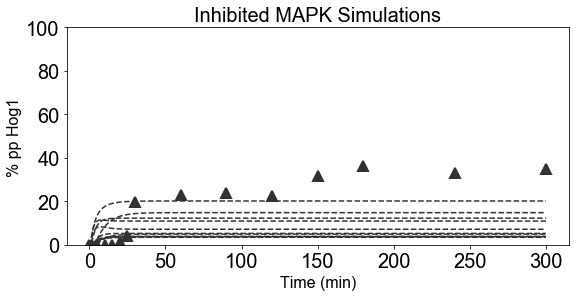

In [20]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M1_fxns, M1_sorted_thetas_EA, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


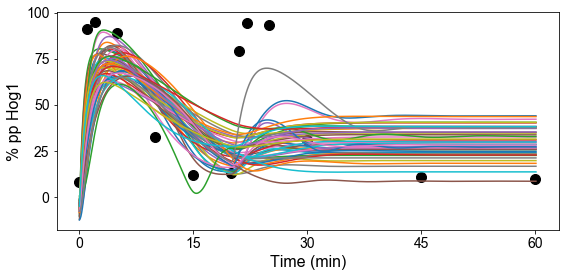

In [21]:
plotting.plt_ramp_behaviors(M1_fxns, M1_sorted_thetas_EA, 50, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

In [ ]:
pre_ea_params

## Params fig

In [1]:
# df_top_thetas_EA = pd.DataFrame(pre_ea_params)
# df_top_thetas_EA.columns = labelnames

num_plt = 1000
df_plt = pd.DataFrame(pre_ea_params[:num_plt])
df_plt.columns = labelnames
df_plt = df_plt.iloc[:,0:5]
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M1', dims, df_plt_log_M, single_theta=df_plt_log, num=0, save_fig="C:/Users/sksuzuki/Documents/Research/figures/paper1/fig2/B_1.pdf") #black dot is best param

NameError: name 'pd' is not defined

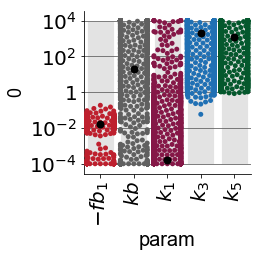

In [55]:
num_plt = 1000
df_plt = pd.DataFrame(M1_sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt = df_plt.iloc[:,0:5]
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M1', dims, df_plt_log_M, single_theta=df_plt_log, num=0, save_fig="C:/Users/sksuzuki/Documents/Research/figures/paper1/fig2/B_2.pdf") #black dot is best param

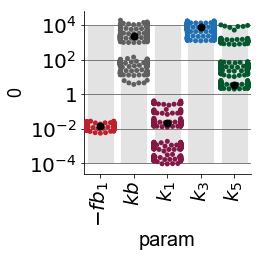

In [52]:
# thetas_e4_sort_M2b_kb = pd.read_csv()

num_plt = 1000
df_plt = pd.DataFrame(thetas_e4_sort_M2b_kb[:num_plt])
df_plt.columns = labelnames
df_plt = df_plt.iloc[:,0:5]
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M1', dims, df_plt_log_M, single_theta=df_plt_log, num=0, save_fig="C:/Users/sksuzuki/Documents/Research/figures/paper1/fig2/B_3.pdf") #black dot is best param

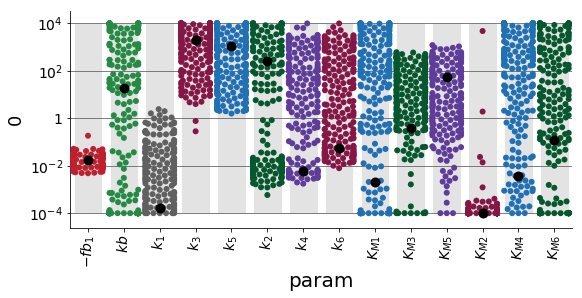

In [12]:
df_top_thetas_EA = pd.DataFrame(M1_sorted_thetas_EA)
df_top_thetas_EA.columns = labelnames

num_plt = 200
df_plt = pd.DataFrame(M1_sorted_thetas_EA[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0) #black dot is best param

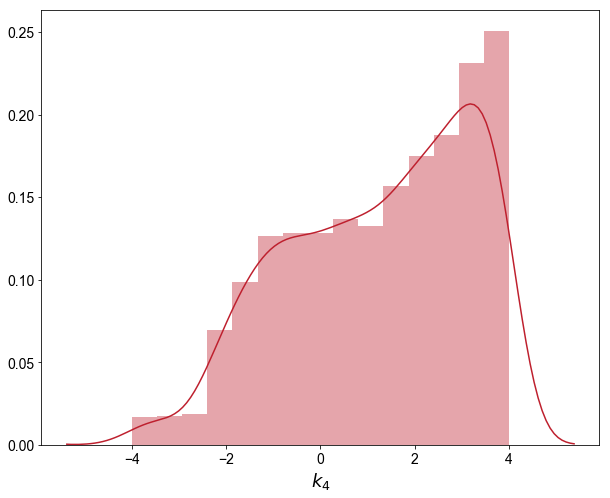

In [23]:
sns.distplot(np.log10(df_top_thetas_EA[labelnames[6]]))

In [42]:
sims_M2c_kb_ea_l = plotting.simdata_to_list(M2c_fxns, M2c_sorted_thetas_EA, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


9% complete.
19% complete.
29% complete.
39% complete.
49% complete.
59% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


69% complete.
79% complete.
89% complete.
99% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


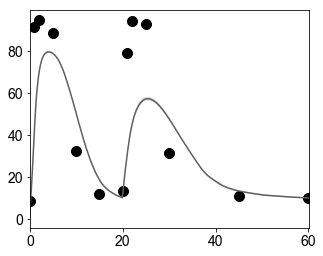

In [46]:
plotting.plt_ramp_cis(sims_1_kb_ea1, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


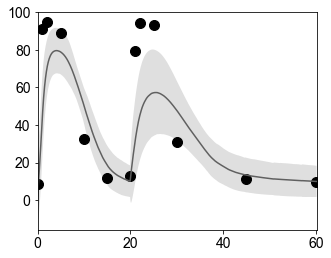

In [47]:
plotting.plt_ramp_cis(sims_M1_kb_ea, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

# SMC

## Try different sizes of EA 

I've been using top 500 and it's worked really well, but here I'm using top 20 so that it runs fast

In [30]:
M1_new_mses_EA, M1_new_thetas_EA = recalc_mses(M1_fxns, M1_sorted_thetas_EA, exp_data, exp_time, params_constants, initials)

print(M1_new_mses_EA[:10])

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[3012.05995806 3052.67405972 3128.07526428 3325.50745933 3332.83148319
 3337.79419102 3395.80358297 3514.84910769 3530.25670195 3842.90036286]


No handles with labels found to put in legend.


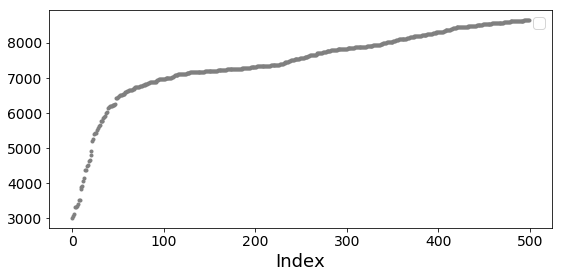

In [31]:
# plotting.plt_idx_vs_mse(M1_new_mses_EA, len(M1_new_mses_EA))
plotting.plt_idx_vs_mse(M1_new_mses_EA, 500)

In [32]:
M1_EA_thetas_1perc = M1_new_thetas_EA[:500]
M1_EA_mses_1perc = M1_new_mses_EA[:500]

## Define schedules

I've been messing around with where I start with the schedule and how many schedules to run

In [33]:
e1, e2, e3, e4 = def_schedules(M1_EA_mses_1perc)

print("Best MSE: " + str(M1_EA_mses_1perc[0]))
print("Worst MSE: " + str(M1_EA_mses_1perc[-1]))
print()
print("Schedules: " + str(e1),str(e2),str(e3),str(e4))
print()


Best MSE: 3012.059958056431
Worst MSE: 8635.226149966647

Schedules: 8635.226149966647 5823.643054011539 4417.851506033985 3714.9557320452077



## Define probability

I've also been messing around with the `top` and `bot` params of `scaled_prob_mses`. 
- (.9 and .1) 
- (.95 and .05) 
- (.99 and .01)

I've noticed that with the larger number of EA thetas, the more extreme ranges are better. 
If you start with a small number of EA thetas, being more conservative with the ranges
results in more balanced probabilities.

In [34]:
probs = scaled_prob_mses(M1_EA_mses_1perc, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])


[0.10683361165055467, 0.06255559451970019, 0.035353083857654115, 0.016530717393709368, 0.01621055047235693]
[0.001080041630785814, 0.0010800216019439981, 0.0010794867073614794, 0.0010794259208885978, 0.0010791273904096432]


## Schedule 1

I use `num_theta_primes = 1000`, but set to 100 to be faster.

In [35]:
mses_e1, thetas_e1, count_e1 = run_schedule(M1_EA_thetas_1perc, probs, e1, num_theta_primes=1000)
mses_e1_sort, thetas_e1_sort = sort_mses_thetas(mses_e1, thetas_e1)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize

10% complete.


../../python_modules\model.py:244: RuntimeWarning: divide by zero encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+(MAPK/beta_3)*fb))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
../../python_modules\model.py:244: RuntimeWarning: invalid value encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+(MAPK/beta_3)*fb))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


20% complete.


../../python_modules\model_supp.py:162: RuntimeWarning: overflow encountered in square
  mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()
../../python_modules\model_supp.py:182: RuntimeWarning: overflow encountered in square
  mses[i] = ((data - mapk[closest_idxs_t100a_long])**2).mean()
../../python_modules\model_supp.py:187: RuntimeWarning: overflow encountered in square
  mses[i] = ((data - mapk[closest_idxs_mapk])**2).mean()
../../python_modules\model_supp.py:205: RuntimeWarning: overflow encountered in square
  mses[18] = ((data - mapk[closest_idxs_ramp_time])**2).mean()


30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [36]:
df_top_thetas_e1 = pd.DataFrame(thetas_e1_sort)
df_top_thetas_e1.columns = labelnames

df_top_thetas_e1.to_csv('M1_kb_thetas_e1.csv')

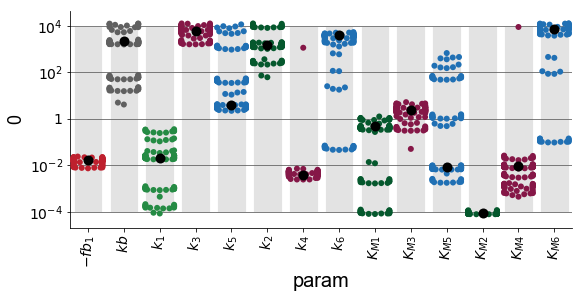

In [36]:
num_plt = 100
df_plt = pd.DataFrame(thetas_e1_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M1_kb', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

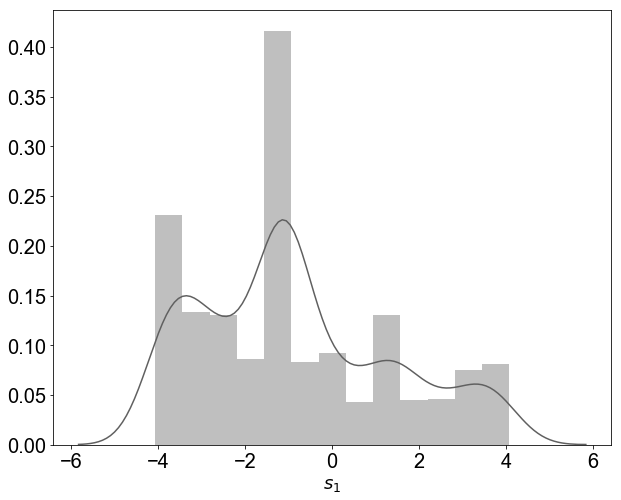

In [120]:
sns.distplot(np.log10(df_top_thetas_e1[labelnames[6]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

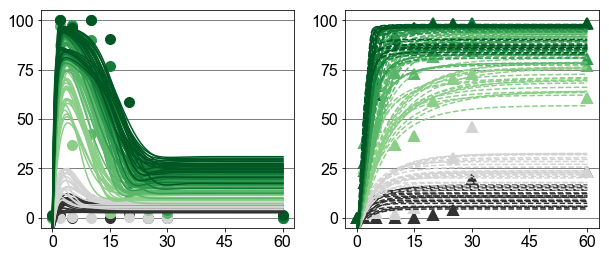

In [76]:
plotting.plt_param_behaviors(M1_fxns, thetas_e1_sort, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

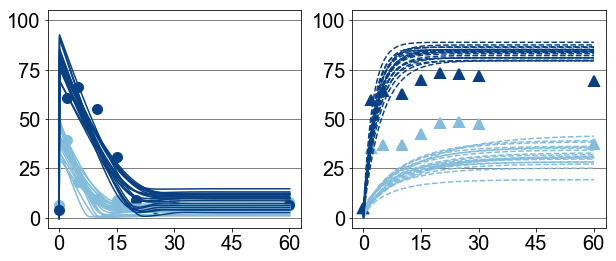

In [77]:
plotting.plt_param_behaviors(M1_fxns, thetas_e1_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

## Schedule 2

Redefine probs based on results of last schedule.

In [37]:
probs = scaled_prob_mses(mses_e1_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.03674510618450687, 0.016244736010397165, 0.013932767826528428, 0.01119484958400568, 0.010066504143156036]
[0.0003714164951928859, 0.00037131060858274797, 0.00037130451310291935, 0.0003712614980195206, 0.0003711626887323926]


In [38]:
mses_e2, thetas_e2, count_e2 = run_schedule(thetas_e1_sort, probs, e2, num_theta_primes=1000)
mses_e2_sort, thetas_e2_sort = sort_mses_thetas(mses_e2, thetas_e2)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:23

10% complete.
20% complete.
30% complete.


../../python_modules\model.py:244: RuntimeWarning: divide by zero encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+(MAPK/beta_3)*fb))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
../../python_modules\model.py:244: RuntimeWarning: invalid value encountered in double_scalars
  dMAP3K = (((sig*k1 + kb)/(1+(MAPK/beta_3)*fb))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [39]:
df_top_thetas_e2 = pd.DataFrame(thetas_e2_sort)
df_top_thetas_e2.columns = labelnames

df_top_thetas_e2.to_csv('M1_kb_thetas_e2.csv')

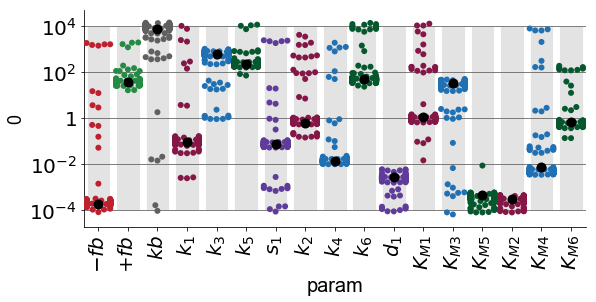

In [126]:
num_plt = 200
df_plt = pd.DataFrame(thetas_e2_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

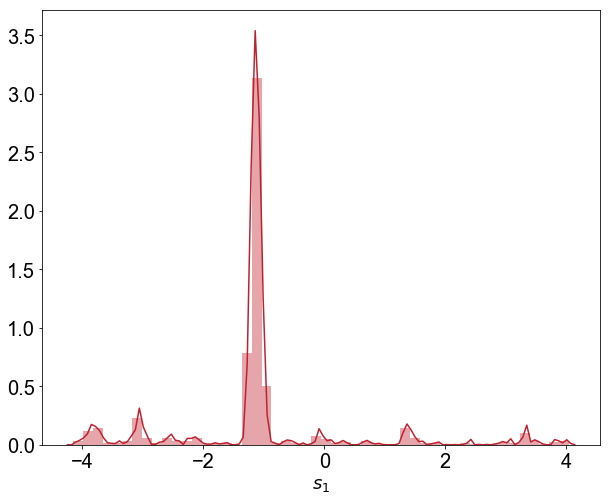

In [127]:
sns.distplot(np.log10(df_top_thetas_e2[labelnames[6]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

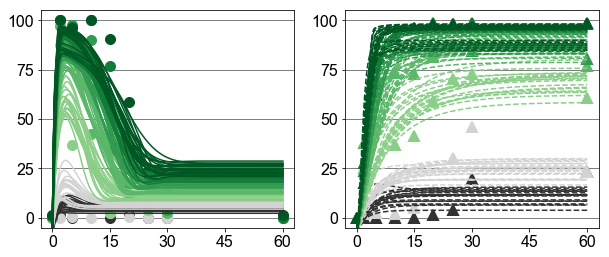

In [85]:
plotting.plt_param_behaviors(M1_fxns, thetas_e2_sort, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

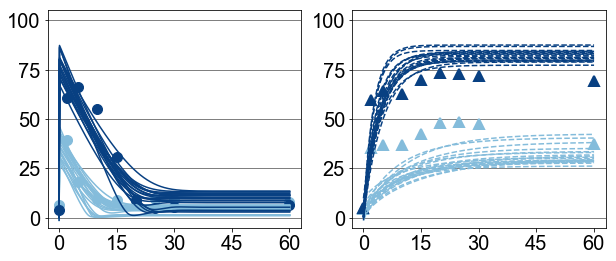

In [86]:
plotting.plt_param_behaviors(M1_fxns, thetas_e2_sort, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [139]:
sims_M2b_kb_e2 = plotting.simdata_to_list(M2c_fxns, thetas_e2_sort, params_constants, initials, time, 2, ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10% complete.
20% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


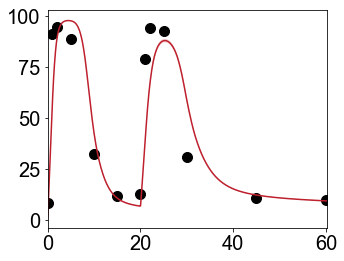

In [140]:
plotting.plt_ramp_cis(sims_M2b_kb_e2, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


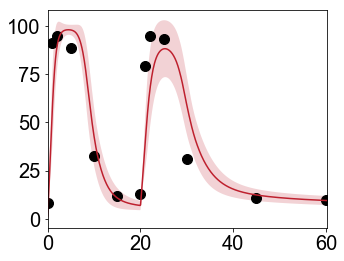

In [141]:
plotting.plt_ramp_cis(sims_M2b_kb_e2, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Turning on and off inhib

In [175]:
M2c_inhib_sims = plotting.inhibdata_to_list(M2c_fxns, thetas_e2_sort, params_constants, initials, time, 2, sig=450000, run_type=['ramp'], ss = True)

0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10% complete.
20% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


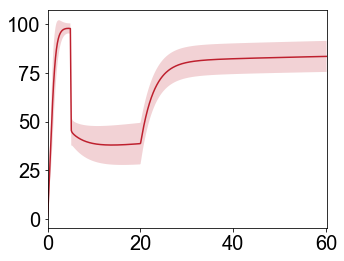

In [176]:
plotting.plt_inhib_cis(M2c_inhib_sims, time, ci="sd") #t>5 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


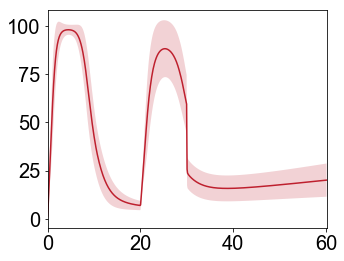

In [174]:
plotting.plt_inhib_cis(M2c_inhib_sims, time, ci="sd") #t>30 with ramp

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


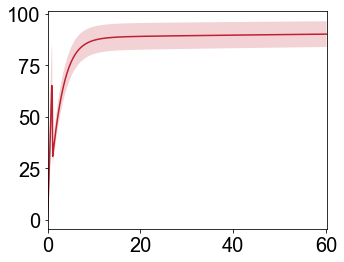

In [167]:
plotting.plt_inhib_cis(M2c_inhib_sims, time, ci="sd") #t>1

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


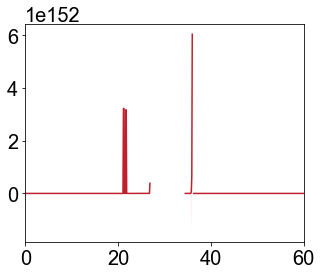

In [165]:
plotting.plt_inhib_cis(M2c_inhib_sims, time, ci="sd") #t<20

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


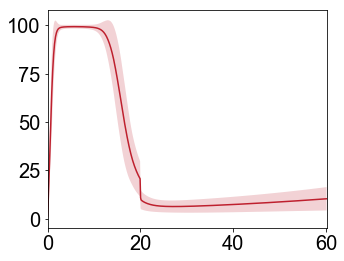

In [163]:
plotting.plt_inhib_cis(M2c_inhib_sims, time, ci="sd") #t>20

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


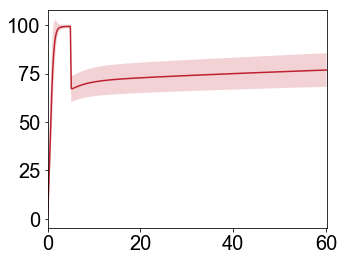

In [161]:
plotting.plt_inhib_cis(M2c_inhib_sims, time, ci="sd") #t>5

### Investigating modality

PCA to see if modality can be explained by theta variance. Also, see if better scores are clustering together.

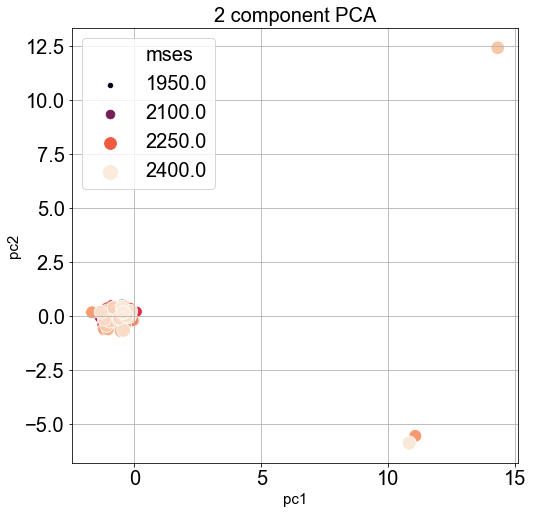

In [310]:
from sklearn.preprocessing import StandardScaler

df_top_thetas_e2_log = df_top_thetas_e2.apply(np.log10)

df_top_thetas_e2_log['mses'] = mses_e2_sort

x = df_top_thetas_e2_log.loc[:, labelnames].values
y = df_top_thetas_e2_log.loc[:,['mses']].values
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3'])

finalDf = pd.concat([principalDf, df_top_thetas_e2_log[['mses']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

sns.scatterplot(x='pc1', y='pc2', hue='mses', size='mses',sizes=(20, 200), data=finalDf[finalDf['mses']<2400], palette="rocket")

ax.grid()

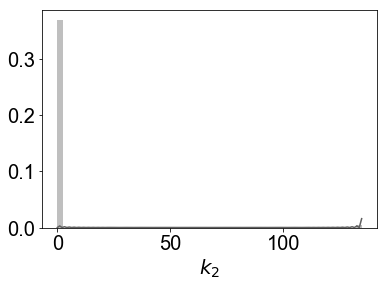

In [311]:
df_top_params_e2 = pd.DataFrame(thetas_e2)
df_top_params_e2.columns = labelnames
sns.distplot(df_top_params_e2[labelnames[7]])

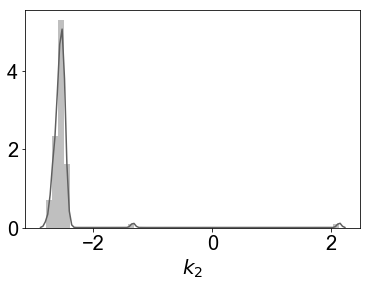

In [312]:
sns.distplot(np.log10(df_top_params_e2[labelnames[7]]))

<Figure size 432x288 with 0 Axes>

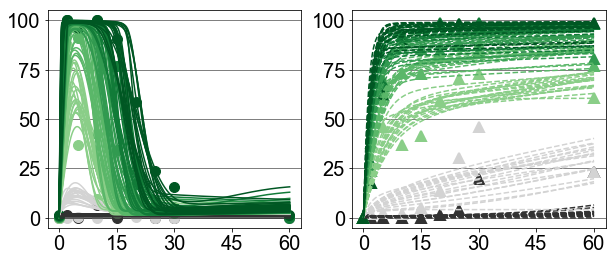

In [314]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

<Figure size 432x288 with 0 Axes>

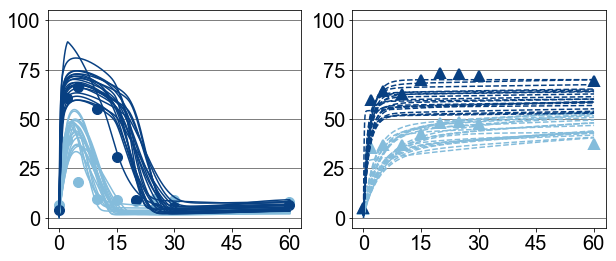

In [315]:
plotting.plt_param_behaviors(M2b_fxns, thetas_e2, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

## Schedule 3 

In [40]:
probs = scaled_prob_mses(mses_e2_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.03830186480609422, 0.010280632327606483, 0.00818933415761493, 0.005291419439094969, 0.004968729052547828]
[0.00038913488365013296, 0.00038805215582174754, 0.0003874212272972152, 0.000387413496087469, 0.00038688752329388087]


In [41]:
mses_e3, thetas_e3, count_e3 = run_schedule(thetas_e2_sort, probs, e3, num_theta_primes=1000)
mses_e3_sort, thetas_e3_sort = sort_mses_thetas(mses_e3, thetas_e3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:23

10% complete.
20% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


30% complete.
40% complete.
50% complete.
60% complete.
70% complete.
80% complete.
90% complete.
100% complete.


In [42]:
df_top_thetas_e3 = pd.DataFrame(thetas_e3_sort)
df_top_thetas_e3.columns = labelnames

df_top_thetas_e3.to_csv('M1_kb_thetas_e3.csv')

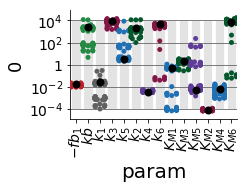

In [43]:
num_plt = 100
df_plt = pd.DataFrame(thetas_e3_sort[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M2a', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

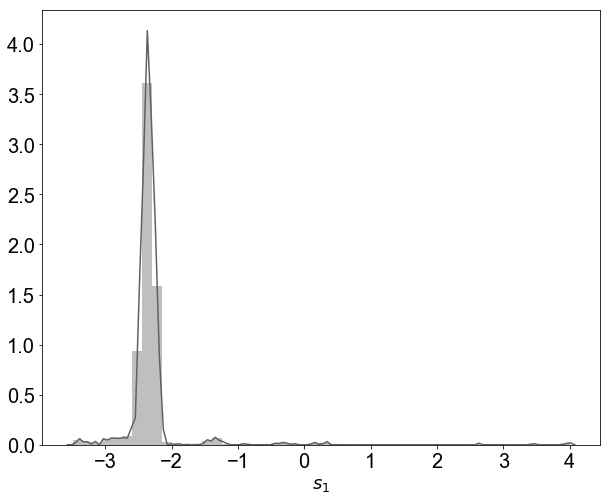

In [44]:
sns.distplot(np.log10(df_top_thetas_e3[labelnames[6]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

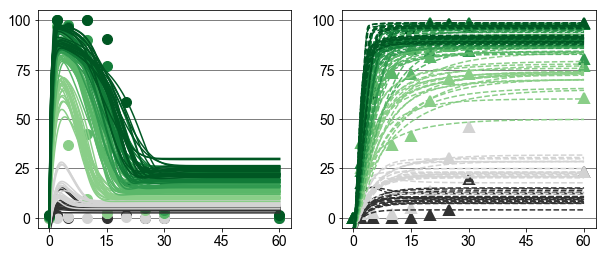

In [44]:
plotting.plt_param_behaviors(M1_fxns, thetas_e3_sort, 20, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

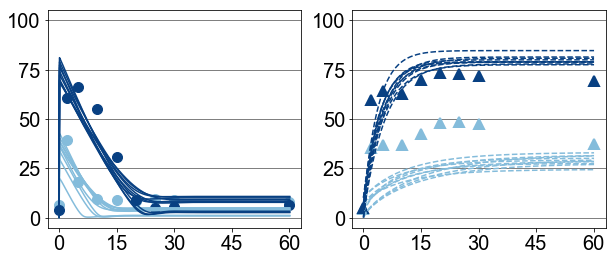

In [94]:
plotting.plt_param_behaviors(M1_fxns, thetas_e3_sort, 10, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [67]:
sims_M2b_kb_e3 = plotting.simdata_to_df(M2b_fxns, thetas_e3_sort, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.
20% complete.
30% complete.
40% complete.
50% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


60% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


70% complete.
80% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


90% complete.


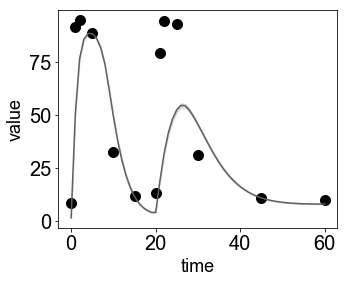

In [83]:
plotting.plt_ramp_cis(sims_M2b_kb_e3, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

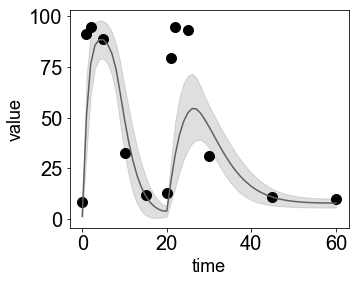

In [81]:
plotting.plt_ramp_cis(sims_M2b_kb_e3, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')

## Schedule 4

In [47]:
probs = scaled_prob_mses(mses_e3_sort, top=.99, bot=.01) 

print(probs[:5]) 
print(probs[-5:])

[0.047444814169745324, 0.02022469828240648, 0.013055231124112396, 0.009940259876688598, 0.006786771175532019]
[0.0004810414051346635, 0.0004810313818666881, 0.0004803678454782591, 0.0004798073045038974, 0.0004792405471691447]


In [48]:
mses_e4_M2b_kb, thetas_e4_M2b_kb, count_e4_M2b_kb = run_schedule(thetas_e3_sort, probs, e4, num_theta_primes=1000)
mses_e4_sort_M2b_kb, thetas_e4_sort_M2b_kb = sort_mses_thetas(mses_e4_M2b_kb, thetas_e4_M2b_kb)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\sci

10% complete.
20% complete.
30% complete.
40% complete.
50% complete.
60% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


70% complete.
80% complete.
90% complete.
100% complete.


In [49]:
df_top_thetas_e4_m2b_kb = pd.DataFrame(thetas_e4_sort_M2b_kb)
df_top_thetas_e4_m2b_kb.columns = labelnames
df_top_thetas_e4_m2b_kb.to_csv('M1_kb_thetas_e4.csv')

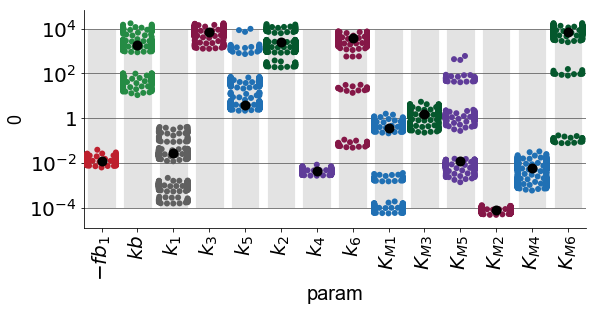

In [99]:
num_plt = 1000
df_plt = pd.DataFrame(df_top_thetas_e4_m2b_kb[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

plotting.plt_param_ranges(labelnames, 'M1', dims, df_plt_log_M, single_theta=df_plt_log, num=0)

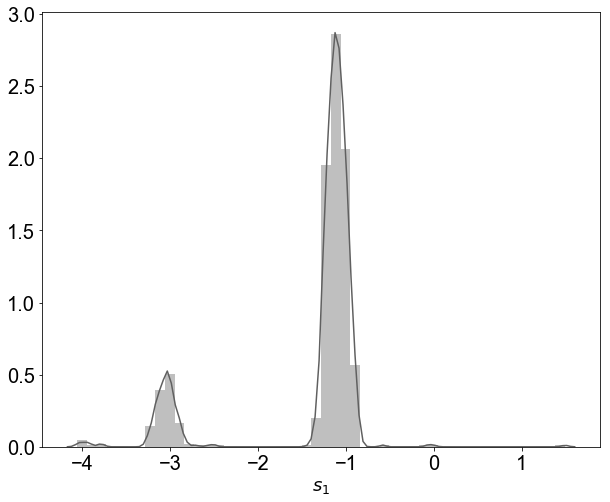

In [79]:
sns.distplot(np.log10(df_top_thetas_e4_m2b_kb[labelnames[6]]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

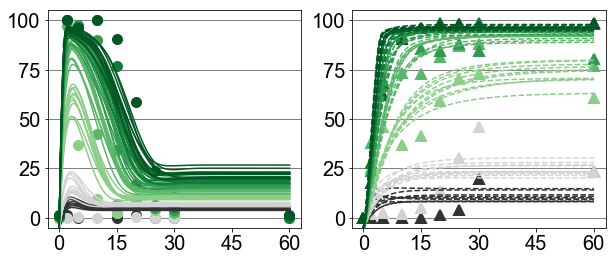

In [100]:
plotting.plt_param_behaviors(M1_fxns, thetas_e4_sort_M2b_kb, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ptp23D=False, ss=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

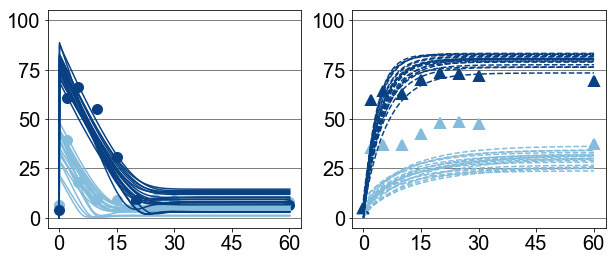

In [56]:
plotting.plt_param_behaviors(M1_fxns, thetas_e4_sort_M2b_kb, 20, params_constants, initials,  [150000, 550000], time, 1, map2k_wt_data, map2k_t100a_data, mapk_time,ss=True)

In [82]:
sims_M2c_kb_e4 = plotting.simdata_to_list(M2c_fxns, thetas_e4_sort_M2b_kb, params_constants, initials, time, 2, ss = True)

0% complete.
10% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


20% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


30% complete.
40% complete.
50% complete.
60% complete.
70% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


80% complete.
90% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


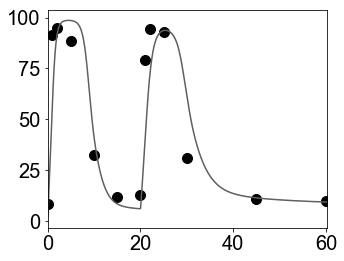

In [85]:
plotting.plt_ramp_cis(sims_M2c_kb_e4, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


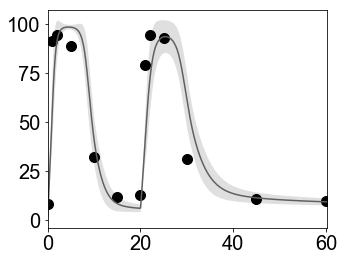

In [87]:
plotting.plt_ramp_cis(sims_M2c_kb_e4, time, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time, ci='sd')